# Probabilistic Programming for Cosmology with JAX
<a target="_blank" href="https://colab.research.google.com/github/hsimonfroy/talks/blob/main/2024CoPhy/ppl4cosmo_color.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# @title Install
%pip install -q numpyro getdist
%pip install -q git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples, gaussian_mixtures

from jax import numpy as jnp, random as jr, jit, grad, value_and_grad, hessian, vmap, tree, debug

import numpyro.distributions as dist
from numpyro import sample, deterministic, plate, infer, render_model
from numpyro.handlers import seed, condition, trace
from numpyro.infer.util import log_density

%matplotlib inline
%load_ext autoreload
%autoreload 2

feynmangpu04.cluster.local
gpu


# N-body model

## N-body with JaxPM

In [2]:
# @title Define plotting utils
from PIL import Image
def load_image(im_path, size=None, bg='WHITE'):
    img = Image.open(im_path).convert('RGBA')
    white_bg = Image.new('RGBA', img.size, bg)
    # img = Image.alpha_composite(white_bg, img).convert('L')
    img = Image.alpha_composite(white_bg, img)

    if size is not None:
        img = img.resize(size)
    # return np.array(img)
    return np.array(img)[...,:3]

def load_mesh(im_path, depth, size=None, bg='WHITE'):
    img = load_image(im_path, size, bg)
    display(img)
    mesh = jnp.broadcast_to(np.expand_dims(np.moveaxis(img[::-1], 0 ,1), 2), (*img.shape[:2], depth, img.shape[2]))
    print(f"{mesh.shape=}")
    return (1 - mesh.astype(jnp.float32) / 255)

from matplotlib import animation, rc
from matplotlib.colors import to_rgba_array
rc('animation', html='html5')

def plot_mesh(meshes, i, vlim, cmap="binary", **config):
    mesh_shape, box_shape = config['mesh_shape'], config['box_shape']
    xx, yy = jnp.indices(mesh_shape[:2]) * (box_shape/mesh_shape)[:2,None,None]
    vmin, vmax = vlim
    # vmin = np.min(meshes[i]) if vmin is None else vmin
    # vmax = np.max(meshes[i]) if vmax is None else vmax
    vmin = np.quantile(meshes[i], 0.01) if vmin is None else vmin
    vmax = np.quantile(meshes[i], 0.99) if vmax is None else vmax

    img = np.array(meshes[i].mean(-2))
    colors = img.reshape(-1, 3)
    colors = np.clip(1 - (colors - vmin) / (vmax - vmin), 0, 1)
    quad = plt.pcolormesh(xx, yy, img[:,:,0], facecolors=colors)
    quad.set_array(None)
    plt.xlabel("$x$ [Mpc/$h$]"), plt.ylabel("$y$ [Mpc/$h$]")
    plt.gca().set_aspect(1)
    return quad

def plot_meshes(meshes, titles=None, joint_scale=False, cmap="binary", **config):
    meshes = np.asarray(meshes)
    if joint_scale:
        vlim = np.quantile(meshes, 0.01), np.quantile(meshes, 0.99)
        # vlim = np.min(meshes), np.max(meshes)
    else:
        vlim = None,None

    plt.figure(figsize=(5*len(meshes), 5))
    for i_mesh, mesh in enumerate(meshes):
        plt.subplot(1, len(meshes), i_mesh+1)
        plot_mesh(meshes, i_mesh, vlim, cmap, **config)

        if titles is not None:
            plt.title(titles[i_mesh])
        if not joint_scale:
            plt.colorbar()
    plt.tight_layout()

def animate_meshes(meshes, cmap="binary", **config):
    meshes = np.asarray(meshes)
    vlim = np.quantile(meshes, 0.01), np.quantile(meshes, 0.99)
    # vlim = np.min(meshes), np.max(meshes)
    vmin, vmax = vlim
    quad = plot_mesh(meshes, 0, vlim, cmap, **config)
    plt.colorbar()

    def update(i):
        if i < len(meshes):
            colors = meshes[i].mean(-2).reshape(-1, 3)
            quad.set_facecolor(np.clip(1 - (colors - vmin) / (vmax - vmin), 0 ,1))
            # quad.set_array(meshes[i].mean(-1))
        return quad,

    anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes)+10, interval=100, blit=True)
    plt.close()
    display(anim)

Galaxy surveys build 3D maps of the universe by measuring galaxy redshifts. From such galaxy catalogs, we can observe the **Baryonic Acoustic Oscillations** (BAO), a manifestation of the evolved primordial fluctuations...

Wait actually, it is not the BAO, it is **BaoBan**, the wild coyote and [DESI embassador](https://www.desi.lbl.gov/2023/05/11/the-new-desi-ambassador-baoban/)!

<div>
<img src="https://raw.githubusercontent.com/hsimonfroy/talks/main/2024CoPhy/BaoBan2.png" width="200"/>
</div>


How is it possible that the matter primordial fluctuations collapsed into this capricious face?

Is it $\Lambda\text{CDM}$ compatible? **Could we reconstruct its initial conditions?**

File ‘BaoBan.png’ already there; not retrieving.



/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

mesh.shape=(128, 128, 8, 3)


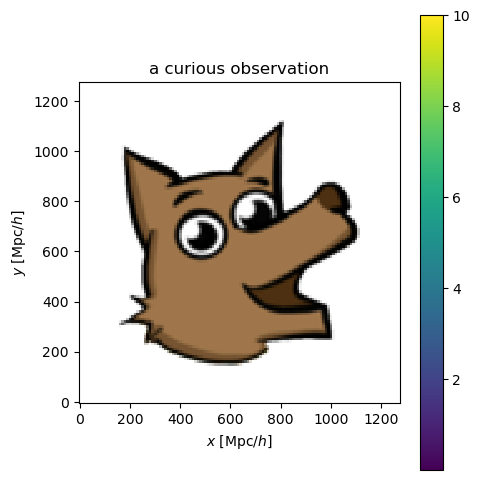

In [14]:
# @title Load and plot observation
!wget -nc https://raw.githubusercontent.com/hsimonfroy/talks/main/2024CoPhy/BaoBan.png
im_path = "./BaoBan.png"
obs_mesh = load_mesh(im_path, depth=8, size=(128,128)) * 10

config = {
    'mesh_shape': obs_mesh.shape[:3],
    'box_shape': np.array(obs_mesh.shape[:3]) * 10, # in Mpc/h
    'a_lpt': 0.1,
    'a_obs': 1.,
    'std_obs': 1.,
    'n_snapshots': 30,
}

plot_meshes([obs_mesh], ["a curious observation"], **config)

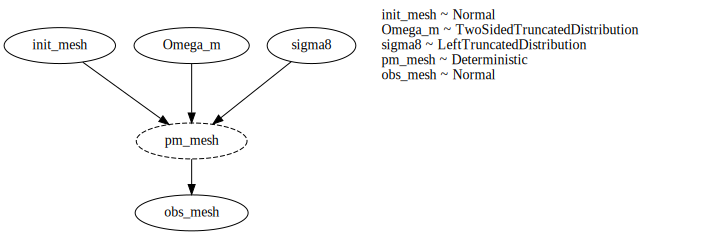

In [15]:
# @title Define a simple matter density field model
from jax import config as jconf
jconf.update('jax_enable_x64', True)
import jax_cosmo as jc
from jaxpm.painting import cic_paint
from jaxpm.pm import lpt, make_ode_fn
from jaxpm.kernels import fftk
from jax.experimental.ode import odeint

def get_cosmology(Omega_m, sigma8):
    return jc.Planck15(Omega_c=Omega_m - jc.Planck15.keywords['Omega_b'], sigma8=sigma8)


def linear_pk_interp(cosmology, a=1., n_interp=128):
    """
    Return a light emulation of the linear matter power spectrum.
    """
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmology, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
    return pk_fn


def get_init_mesh(init_mesh_, cosmology,
                  mesh_shape, box_shape, **config):
    """
    Return initial conditions at a=1 from latent params.
    """
    # Compute initial power spectrum
    pk_fn = linear_pk_interp(cosmology)
    kvec = fftk(mesh_shape)
    k_box = sum((ki  * (m / l))**2 for ki, m, l in zip(kvec, mesh_shape, box_shape))**0.5
    pk_mesh = pk_fn(k_box) * (mesh_shape / box_shape).prod() # NOTE: convert from (Mpc/h)^3 to cell units

    # Apply transfer function
    delta_k = jnp.fft.rfftn(init_mesh_)
    delta_k *= pk_mesh**0.5
    init_mesh = jnp.fft.irfftn(delta_k)
    return init_mesh


def nbody(init_mesh, cosmology,
          mesh_shape, a_lpt, a_obs, n_snapshots, **config):
    """
    Compute matter field at a_lpt then evolve it to a_obs.
    """
    # Initial displacement
    pos = jnp.indices(mesh_shape).reshape(3,-1).T
    cosmology._workspace = {}
    dx, p, f = lpt(cosmology, init_mesh, pos, a_lpt)

    # Evolve the simulation forward
    snapshots = jnp.linspace(a_lpt, a_obs, n_snapshots)
    pos, p = odeint(make_ode_fn(mesh_shape), [pos+dx, p], snapshots, cosmology, rtol=1e-3, atol=1e-3)
    return jnp.stack([cic_paint(jnp.zeros(mesh_shape), pos_i) for pos_i in pos])


def mean_model(init_mesh, Omega_m, sigma8, **config):
    cosmology = get_cosmology(Omega_m, sigma8)
    init_mesh = vmap(partial(get_init_mesh, cosmology=cosmology, **config), in_axes=-1, out_axes=-1)(init_mesh) ###
    meshes = vmap(partial(nbody, cosmology=cosmology, **config), in_axes=-1, out_axes=-1)(init_mesh)
    return meshes


def prior_model(mesh_shape, **config):
    init_mesh = sample('init_mesh', dist.Normal(0, 1).expand((*mesh_shape, 3)))
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.31, 0.5, low=jc.Planck15.keywords['Omega_b'], high=1.))
    sigma8 = sample('sigma8', dist.TruncatedNormal(0.81, 0.5, low=0.))
    params = dict(init_mesh = init_mesh,
                  Omega_m = Omega_m,
                  sigma8 = sigma8,)
    return params


def lik_model(params, std_obs, **config):
    pm_mesh = mean_model(**params, **config | dict(n_snapshots=2))[-1]
    pm_mesh = deterministic('pm_mesh', pm_mesh)
    return sample('obs_mesh', dist.Normal(pm_mesh, std_obs))


def model(**config):
    params = prior_model(**config)
    return lik_model(params, **config)


model = partial(model, **config)
render_model(model, render_distributions=True, render_params=True)

Thanks to [JaxPM](https://github.com/DifferentiableUniverseInitiative/JaxPM/) from the *Differentiable Universe Initiative*, we can build fast and differentiable N-body simulators. [Multi-GPU version](https://github.com/DifferentiableUniverseInitiative/JaxPM/tree/ASKabalan/jaxdecomp_proto) coming soon!

We can then condition on cosmology, meshes, particles positions and velocities, etc. and compute many model log density and derivatives.

In the following, we condition on both observed mesh and cosmology, but one could also relax cosmology and optimize or sample from it.

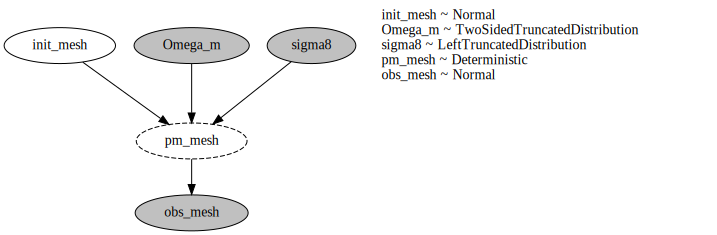

In [16]:
start_params = dict(init_mesh = jr.normal(jr.key(0), (*config['mesh_shape'], 3)),)
obs = dict(obs_mesh=obs_mesh)
cosmo = dict(Omega_m=0.31, sigma8=0.81)
obs |= cosmo
# start_params |= cosmo

obs_model = condition(model, obs)
render_model(obs_model, render_distributions=True, render_params=True)

## Posterior mode

In [17]:
potential_fn = lambda params: -log_density(obs_model, (), {}, params)[0]
###################
# TODO: Compute the potential value and gradient function, and jit it
potential_valgrad_fn = jit(value_and_grad(potential_fn))
###################

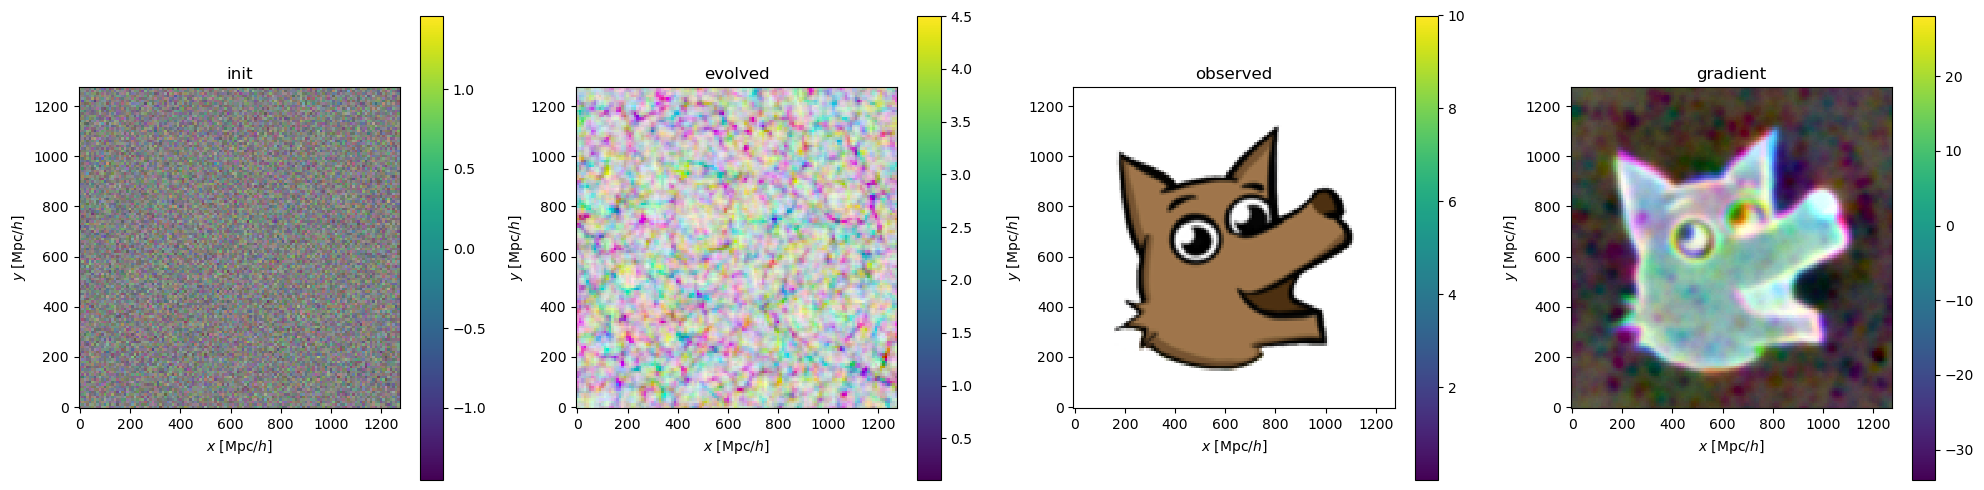

In [18]:
# @title Plot the starting optimization state
get_pm_meshes = partial(mean_model, **cosmo, **config)
def plot_optim_state(params):
    pm_meshes = get_pm_meshes(**params)
    animate_meshes(pm_meshes, **config)
    # plot_meshes(meshes, joint_scale=True, **config)

    meshes = jnp.stack([params['init_mesh'], pm_meshes[-1], obs_mesh, potential_valgrad_fn(params)[1]['init_mesh']])
    titles = ['init', 'evolved', 'observed', 'gradient']
    plot_meshes(meshes, titles, cmap='viridis', **config)
    return pm_meshes[-1]

pm_mesh = plot_optim_state(start_params)

In [19]:
# Let us use a simple Adam optimizer
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = .1
n_epochs = 1000
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(start_params)

def step(step, opt_state):
    value, grads = potential_valgrad_fn(get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params = get_params(opt_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


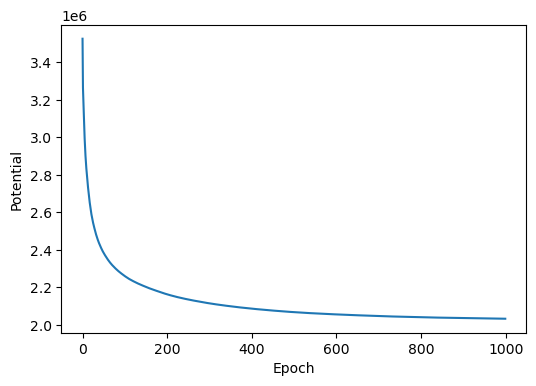

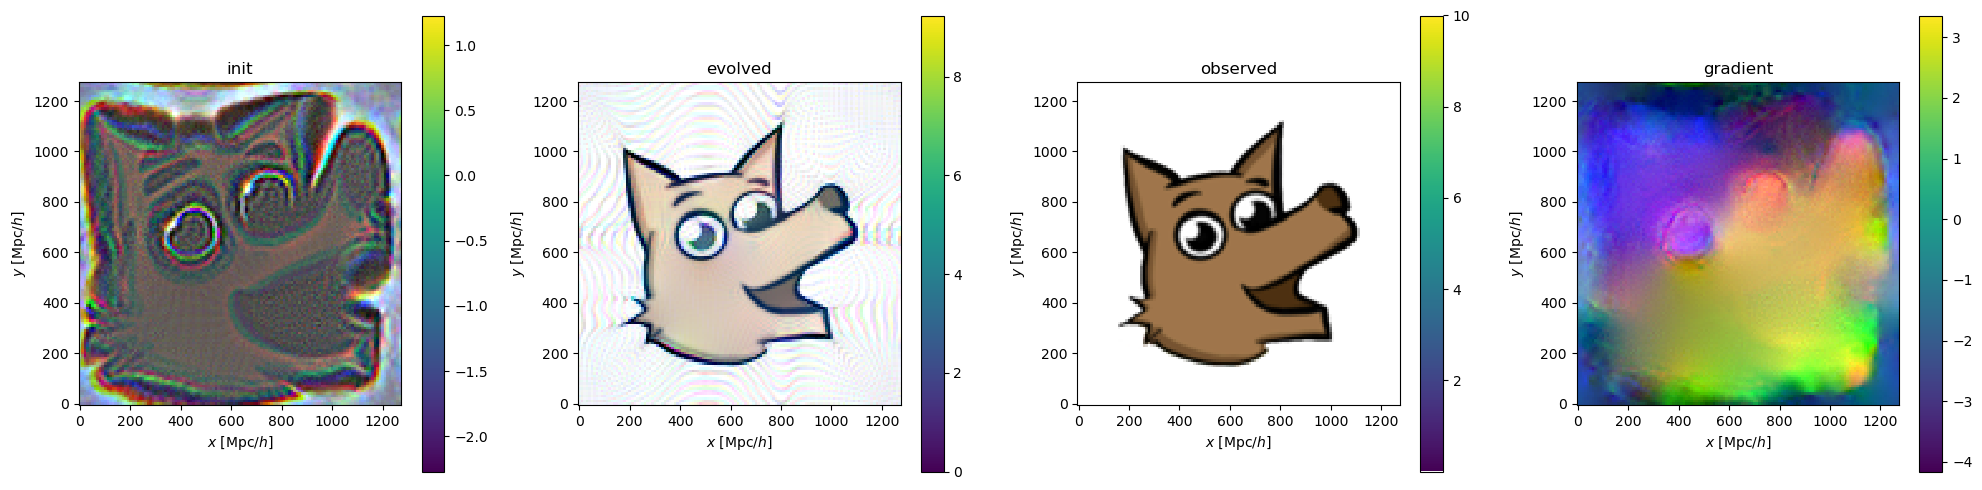

In [20]:
# @title Plot loss and final optimization state
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()
pm_mesh_mode = plot_optim_state(params)

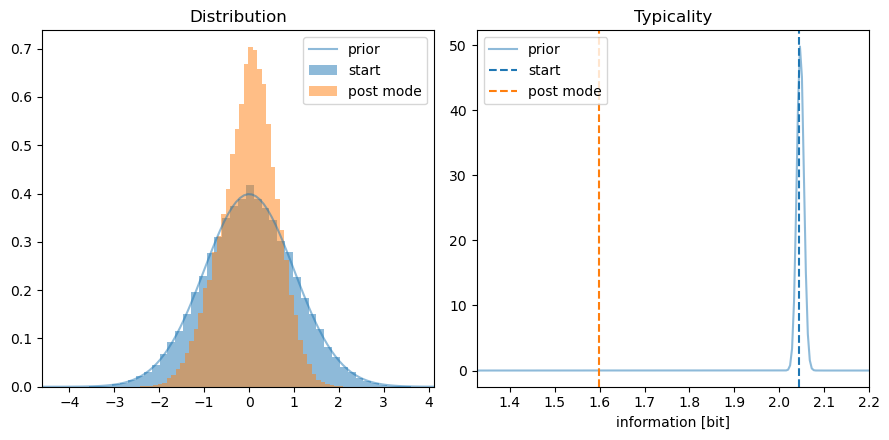

In [237]:
# @title Compare fields distribution and typicality
from scipy.stats import chi2, norm
prior_pdf = lambda x: norm.pdf(x, loc=0, scale=1)

plt.figure(figsize=(9,4.5))
plt.subplot(1,2,1)
xlim = start_params['init_mesh'].min(), start_params['init_mesh'].max(),
xs = np.linspace(*xlim, 100)
plt.plot(xs, prior_pdf(xs), 'C0', alpha=0.5, label="prior")
plt.hist(start_params['init_mesh'].ravel(), bins=50, density=True, alpha=0.5, label="start")
plt.hist(params['init_mesh'].ravel(), bins=50, density=True, alpha=0.5, label="post mode")
plt.xlim(*xlim)
plt.title("Distribution")
plt.legend()

def minfo_fn(x):
    reduced_chi2 = (x**2).mean()
    return (np.log(2*np.pi) + reduced_chi2) / (2*np.log(2))

def minfo_logpdf(minfo, d):
    # i.e. shifted chi2 logpdf
    return chi2.logpdf(d*(minfo * 2*np.log(2) - np.log(2*np.pi)), d) + np.log(d *2*np.log(2))

plt.subplot(1,2,2)
xlim = np.log2(2*np.pi)/2, 2.2
rs = np.linspace(*xlim, 200)
dof = np.prod(config['mesh_shape'])

plt.plot(rs, np.exp(minfo_logpdf(rs, dof)), alpha=0.5, label="prior")
plt.xlim(*xlim), plt.ylim(*plt.ylim())
plt.vlines(minfo_fn(start_params['init_mesh']), *plt.ylim(), 'C0', linestyle='--', label="start")
plt.vlines(minfo_fn(params['init_mesh']), *plt.ylim(), 'C1', linestyle='--', label="post mode")
plt.xlabel("information [bit]")
plt.title("Typicality"), plt.legend()
plt.tight_layout(), plt.show();

## Posterior sampling

Actually, we are not interested solely in the posterior mode, but in the **full posterior distribution**. From it we can extract other relevant quantities such as the posterior mean, std, quantiles, or highest density regions (contours).

This time, the latent space is not 2 cosmological parameters but **a whole initial field**!

We can naively feed it directly to an efficient MCMC sampler and it would still produce posterior samples, but very slowly. This is due to:
1. High dimensional sampling implies more model evaluations per effective sample. Typically $n_{\text{eval}} \approx d^{1/4}$ for HMC, vs. $n_{\text{eval}} \approx d$ for MH.
2. Each model evaluation requires a N-body simulation, which is the computational bottleneck. Typically, time complexity of PM is in $O(d \log d)$.

**High-dimensional sampling is then a challenge for field-level inference**, which aims at infering cosmology and initial field from uncompressed observed field.

In [ ]:
nuts_kernel = infer.NUTS(obs_model, max_tree_depth=6, init_strategy=infer.init_to_value(values=params),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=30, num_samples=170, num_chains=4, chain_method='vectorized')
mcmc.run(jr.key(43), extra_fields=['num_steps'])

samples, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("n_evals:", extra['num_steps'].sum())
# mcmc.print_summary()

sample:  86%|████████▌ | 172/200 [16:12<02:42,  5.79s/it]

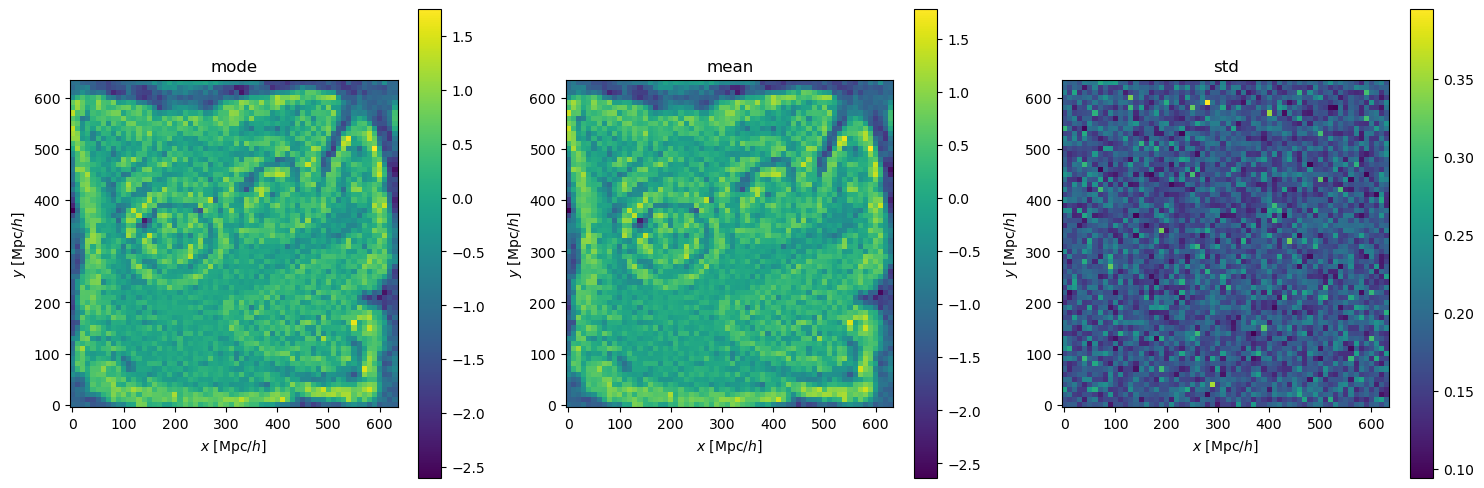

In [14]:
# @title Plot posterior
post_meshes = samples['init_mesh']
meshes = jnp.stack([params['init_mesh'], post_meshes.mean(0), post_meshes.std(0)])
titles = ['mode', 'mean', 'std']
animate_meshes(post_meshes[::10], **config)
plot_meshes(meshes, titles, cmap='viridis', **config)

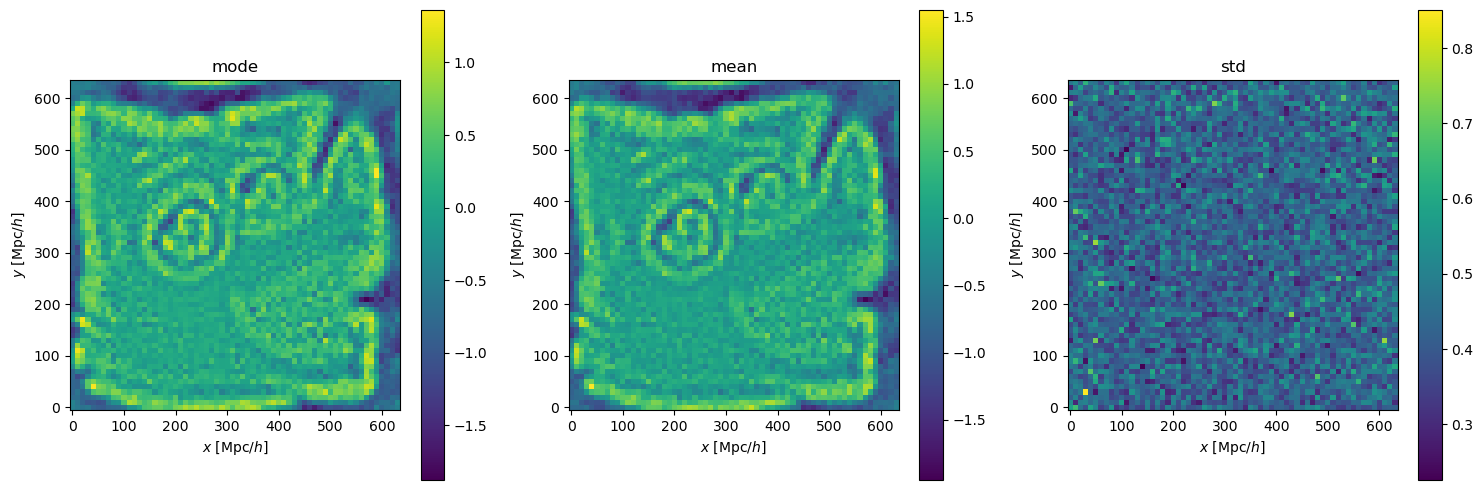

In [ ]:
# @title Plot posterior
post_meshes = samples['init_mesh']
meshes = jnp.stack([params['init_mesh'], post_meshes.mean(0), post_meshes.std(0)])
titles = ['mode', 'mean', 'std']
animate_meshes(post_meshes[::10], **config)
plot_meshes(meshes, titles, cmap='viridis', **config)

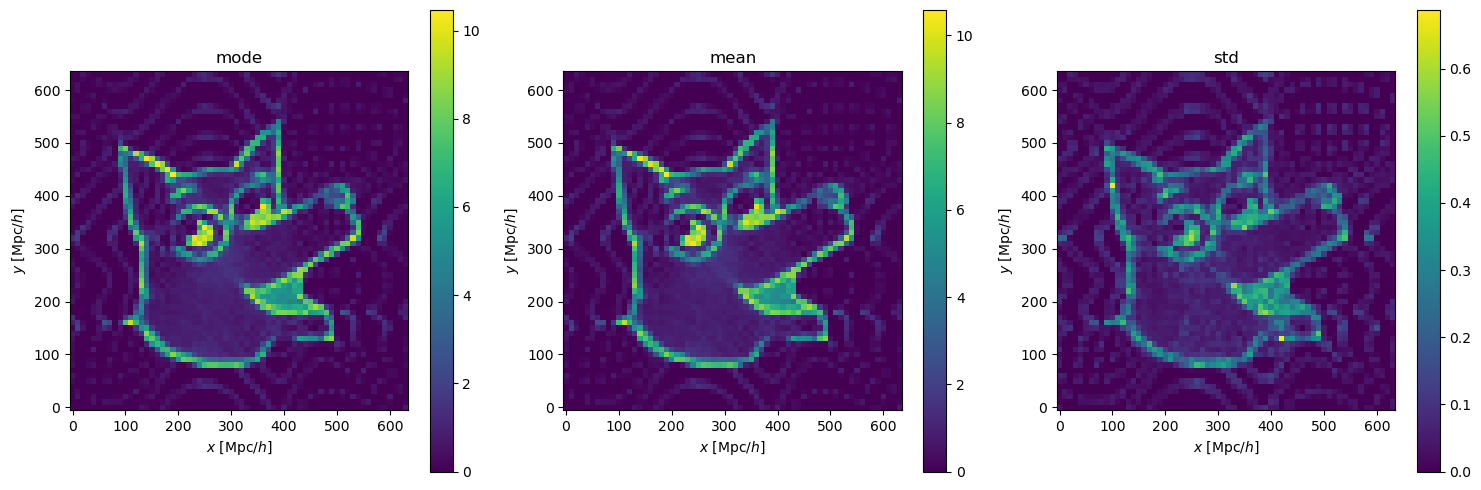

In [20]:
# @title Plot posterior predictive
post_meshes = samples['pm_mesh']
meshes = jnp.stack([pm_mesh_mode, post_meshes.mean(0), post_meshes.std(0)])
titles = ['mode', 'mean', 'std']
animate_meshes(post_meshes[::10], **config)
plot_meshes(meshes, titles, cmap='viridis', **config)

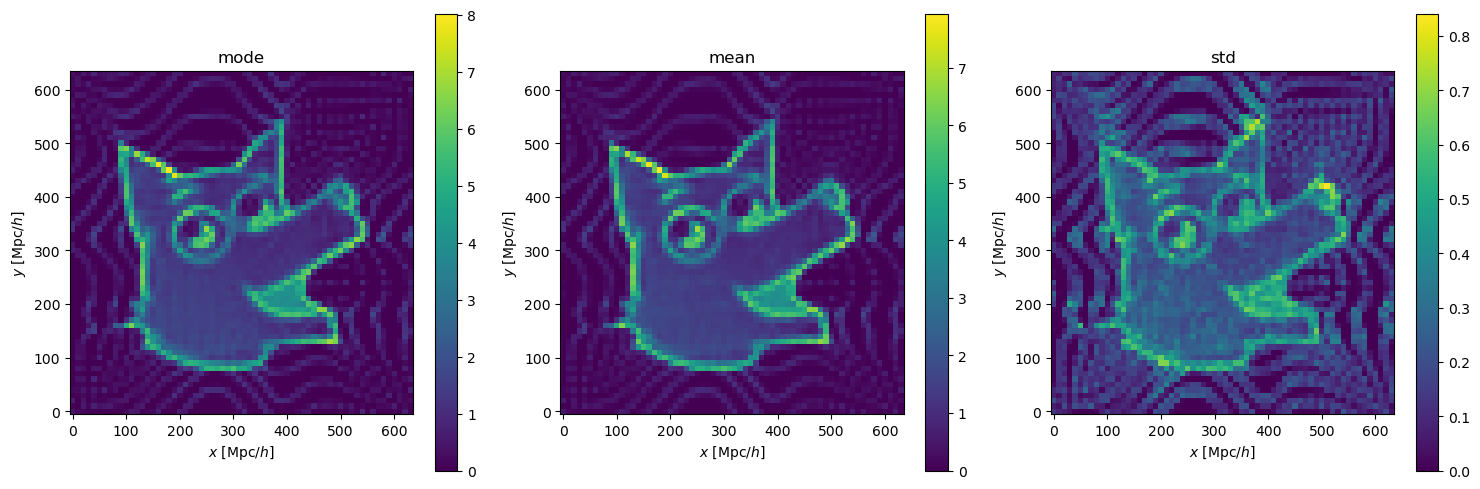

In [ ]:
# @title Plot posterior predictive
post_meshes = samples['pm_mesh']
meshes = jnp.stack([pm_mesh_mode, post_meshes.mean(0), post_meshes.std(0)])
titles = ['mode', 'mean', 'std']
animate_meshes(post_meshes[::10], **config)
plot_meshes(meshes, titles, cmap='viridis', **config)